In [1]:
# Import librairies
from typing import TypedDict, List
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
class EmbeddingModel(TypedDict):
    name: str
    tokenizer: BertTokenizer
    model: BertModel

class EmbeddingModelResult(TypedDict):
    model_name: str
    weat_score: float

class ExperimentSetup(TypedDict):
    name: str
    A1: List[str]
    A2: List[str]
    W1: List[str]
    W2: List[str]

class ExperimentResult(TypedDict):
    name: str
    results: List[EmbeddingModelResult]

In [3]:
def encode_word_list(word_list: List[str], tokenizer, model):
    tokenized_words = tokenizer.batch_encode_plus(word_list, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**tokenized_words)

    last_hidden_state = outputs.last_hidden_state
    word_embeddings = last_hidden_state[:, 0, :].numpy()
    embedding_dict = dict()
    for word, embedding in zip(word_list, word_embeddings):
        embedding_dict[word] = embedding
    
    return embedding_dict
    
    
def calculate_association(target_word, W1, W2, embedding_dict): ## function to conpute s(a, W1, W2)
    """
    Calculate the association between a target word and two attribute sets W1 and W2.
    This returns the difference between the mean cosine similarities of the target word
    to W1 and the target word to W2.
    """
    target_embedding = embedding_dict[target_word]

    # Cosine similarities with W1
    similarities_w1 = []
    for word in W1:
        word_embedding = embedding_dict[word]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities_w1.append(similarity)

    # Cosine similarities with W2
    similarities_w2 = []
    for word in W2:
        word_embedding = embedding_dict[word]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities_w2.append(similarity)

    # s(a, W1, W2) = mean(cos(a, w1)) - mean(cos(a, w2))
    return np.mean(similarities_w1) - np.mean(similarities_w2)

def generate_permutations(A1, A2, num_permutations):
    """
    Generate the same permutations (new_A1, new_A2) for all models.
    """
    shared_permutations = []
    
    for _ in range(num_permutations):
        new_A1 = np.random.choice(A1, size=len(A1), replace=True)
        new_A2 = np.random.choice(A2, size=len(A2), replace=True)
        shared_permutations.append((new_A1, new_A2))
    
    return shared_permutations

def diff_association(A1, A2, W1, W2, embedding_dict, shared_permutations):
    A1_similarities = [calculate_association(a1, W1, W2, embedding_dict) for a1 in A1]
    A2_similarities = [calculate_association(a2, W1, W2, embedding_dict) for a2 in A2]
    
    effect_size = (np.mean(A1_similarities) - np.mean(A2_similarities))/np.std(A1_similarities+A2_similarities)
    samples_weat = []
    for new_A1, new_A2 in shared_permutations:
        A11_similarities = [calculate_association(a1, W1, W2, embedding_dict) for a1 in new_A1]
        A21_similarities = [calculate_association(a2, W1, W2, embedding_dict) for a2 in new_A2]
    
        sample_effect_size = (np.mean(A11_similarities) - np.mean(A21_similarities))/np.std(A11_similarities+A21_similarities)
        samples_weat.append(sample_effect_size)
    return effect_size, samples_weat

def run_experiment(experiment_setup: ExperimentSetup, embedding_model_list : List[EmbeddingModel]) -> List[EmbeddingModelResult]:
    total_word_list = experiment_setup["A1"] + experiment_setup["A2"] + experiment_setup["W1"] + experiment_setup["W2"]
    shared_permutations = generate_permutations(experiment_setup["A1"], experiment_setup["A2"], num_permutations=500)
    all_model_results = list()

    for embedding_model in embedding_model_list:
        embedding_dict = encode_word_list(total_word_list, embedding_model["tokenizer"], embedding_model["model"])#
        original_weat,sample_weat_results = diff_association(experiment_setup["A1"], experiment_setup["A2"], experiment_setup["W1"], experiment_setup["W2"], embedding_dict, shared_permutations)

        # Model result
        model_result:EmbeddingModelResult = {
            "model_name": embedding_model["name"],
            "weat_score": original_weat,
            "Samples weat": sample_weat_results
        }

        all_model_results.append(model_result)

    return  all_model_results

# Calculate mean and standard error for bootstrap scores
def calc_stats(scores):
    scores = eval(scores)  # Convert string representation back to list
    return np.mean(scores), np.std(scores) / np.sqrt(len(scores))


In [4]:
# Models used: BERT and SCIBERT

# 1- Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# 2- Load pre-trained SciBERT model and tokenizer
scibert_tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
scibert_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')

embedding_models: List[EmbeddingModel] = [
    {
        "name": "BERT",
        "tokenizer": bert_tokenizer,
        "model": bert_model
    },
    {
        "name": "SciBERT",
        "tokenizer": scibert_tokenizer,
        "model": scibert_model
    }
]

In [5]:
################ Researcher vs Failure ################
experiment_list: List[ExperimentSetup] = [

    {
        "name":"gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],



        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],



        "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
        "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]

    },
    {
        "name": "Socioeconomic_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ["Researcher", "Academia", "Award", "Funding", "PhD", "Doctor", "Affiliation", "Keynote",
      "Cited", "Prize", "Professor", "University", "Successful", "Nobel", "Scholar", "Scientist",
      "Investigator", "Tenure", "Expert"],
      "W2": ["Misconduct", "Academic dismissal", "Retraction", "Grant rejection", "Dropout", "Impostor",
      "Disaffiliation", "Denial", "Plagiarism", "Fraud", "De-tenuring", "Expulsion", "Failed experiment",
      "Scandal", "Pseudoscience", "Quack", "Misconduct investigation", "Tenure denial", "Discredited"]
        }
]
    
experiment_result_list: List[dict] = list()
experiment_names = []
model_names = []
weat_scores = []
sample_scores = []
np.random.seed(42)

# Run each experiment and store results
for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list.append(experiment_result)
    for result in all_model_results:
        experiment_names.append(experiment["name"])
        model_names.append(result['model_name'])
        weat_scores.append(result['weat_score'])
        sample_scores.append(result["Samples weat"])


In [7]:

df = pd.DataFrame({
    'Experiment': experiment_names,
    'Model': model_names,
    'WEAT Score': weat_scores,
    'Bootstrap scores': sample_scores
})
experiment_labels = {
    'gender_bias': 'Male vs Female',
    'race_bias': 'EU vs AA',
    'Field_bias': 'Science vs Arts',
    'Location_bias': 'G_North vs G_South',
    'Prestige_bias': 'P_Inst vs NP_Inst',
    'Socioeconomic_bias': 'High SES vs Low SES'
}
df['Experiment'] = df['Experiment'].replace(experiment_labels)

df['WEAT Score'] = df['WEAT Score'].round(3)
df['Bootstrap Score'] = df['Bootstrap scores'].apply(lambda x: f"[{', '.join([f'{v:.2f}' for v in x])}]")
pivot_df = df.pivot(index='Experiment', columns='Model', values=['WEAT Score', 'Bootstrap Score'])
pivot_df.columns = [f'{metric} {model}' for metric, model in pivot_df.columns]
column_order = ['WEAT Score BERT', 'WEAT Score SciBERT',
                'Bootstrap Score BERT', 'Bootstrap Score SciBERT']
pivot_df = pivot_df[column_order]


In [8]:
pivot_df

,WEAT Score BERT,WEAT Score SciBERT,Bootstrap Score BERT,Bootstrap Score SciBERT
Experiment,,,,
EU vs AA,1.274,0.706,"[1.14, 1.07, 1.21, 1.54, 1.23, 1.30, 0.97, 1.2...","[0.79, 1.04, 0.56, 0.40, 0.62, 0.56, 1.05, 0.9..."
G_North vs G_South,0.591,0.494,"[0.39, 0.95, 0.74, 0.84, 0.45, 0.82, 0.38, 0.7...","[0.02, 0.34, 1.06, 0.53, 0.07, 0.03, 0.38, 0.8..."
High SES vs Low SES,0.533,0.557,"[0.62, 0.47, 0.74, 0.14, 0.61, 0.32, 0.96, 0.1...","[1.00, 0.59, 0.75, -0.00, 0.75, 0.86, 0.58, 0...."
Male vs Female,0.362,0.696,"[-0.25, 0.63, 0.76, 0.32, 0.91, 0.79, 0.74, 0....","[0.14, 0.71, 0.80, 0.59, 0.86, 1.01, 0.99, 0.7..."
P_Inst vs NP_Inst,0.844,0.618,"[1.27, 0.70, 1.53, 0.47, 0.77, 0.41, 1.57, 1.1...","[0.91, 0.53, 1.01, 1.06, 0.61, 1.30, 0.69, 0.3..."
Science vs Arts,-0.268,0.828,"[0.36, -0.34, -0.80, -0.20, -0.87, -1.35, 0.04...","[0.92, 0.68, 1.36, 1.16, 1.27, 0.46, 0.81, 0.4..."


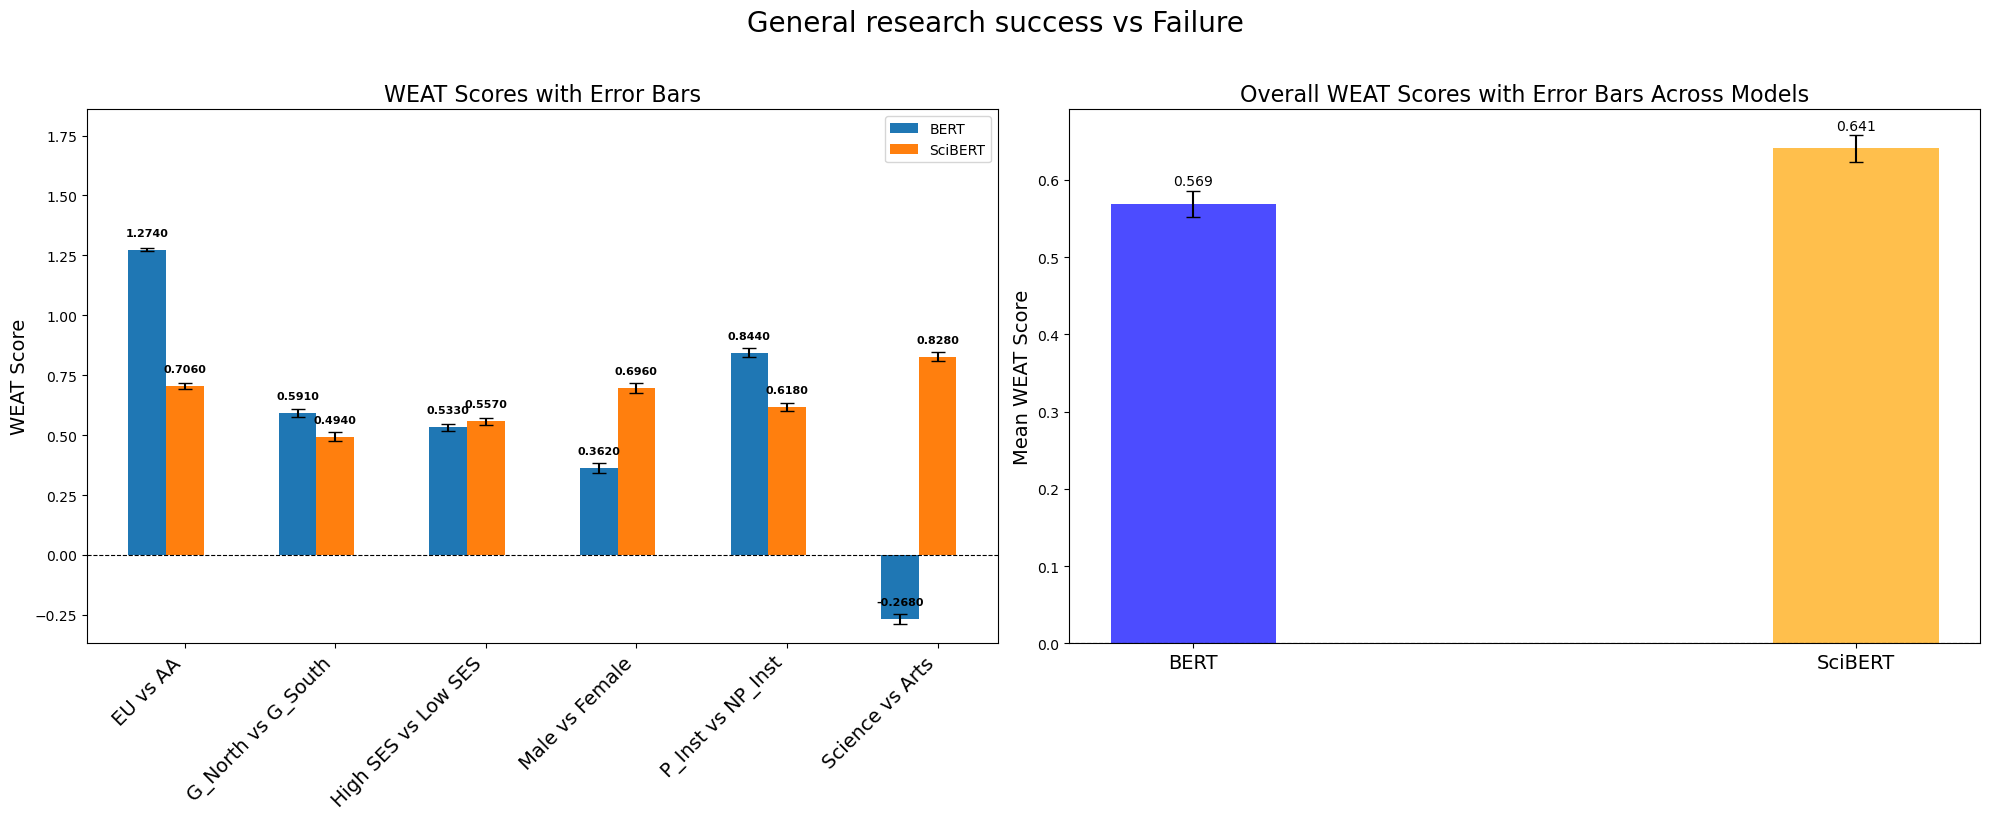

In [15]:
for model in ['BERT', 'SciBERT']:
    pivot_df[f'Mean {model}'], pivot_df[f'SE {model}'] = zip(*pivot_df[f'Bootstrap Score {model}'].apply(calc_stats))

plot_df = pivot_df[[col for col in pivot_df.columns if col.startswith('WEAT Score') or col.startswith('Mean') or col.startswith('SE')]]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

## First plot
width = 0.25
x = np.arange(len(plot_df.index))

def add_bars_and_text(x_pos, data, label, ax):
    bars = ax.bar(x_pos, data, width, label=label, yerr=plot_df[f'SE {label}'], capsize=5)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{data[i]:.4f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    return bars

add_bars_and_text(x - width, plot_df['WEAT Score BERT'], 'BERT', ax1)
add_bars_and_text(x, plot_df['WEAT Score SciBERT'], 'SciBERT', ax1)
ax1.set_ylabel('WEAT Score', fontsize=14)
ax1.set_title('WEAT Scores with Error Bars', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df.index, rotation=45, ha='right', fontsize=14)
ax1.legend(fontsize=10)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
y_min, y_max = ax1.get_ylim()
ax1.set_ylim(y_min, y_max + 0.5)

# Second plot
means = plot_df[['Mean BERT', 'Mean SciBERT']].mean()
ses = plot_df[['SE BERT', 'SE SciBERT']].mean()

x = np.arange(len(means))
ax2.bar(x, means, width, yerr=ses, capsize=5, color=['blue', 'orange'], alpha=0.7)

ax2.set_ylabel('Mean WEAT Score', fontsize=14)
ax2.set_title('Overall WEAT Scores with Error Bars Across Models', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(['BERT', 'SciBERT'], fontsize=14)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

for i, v in enumerate(means):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
fig.suptitle("General research success vs Failure", fontsize=20, y=1.02)

plt.tight_layout()
plt.show()

In [16]:
################### Teacher effectiveness vs Failure ###############
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
        "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']

    },
    {
        "name": "Socioeconomic_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Engagement', 'Clarity', 'Motivation', 'Feedback', 'Understanding', 'Inspiration',
      'Interaction', 'Accessibility', 'Impact', 'Organization', 'Adaptability', 'Enthusiasm',
      'Knowledge', 'Mentorship', 'Communication', 'Relevance', 'Support', 'Guidance',
      'Empowerment', 'Mastery'],
      "W2": ['Disengagement', 'Confusion', 'Apathy', 'Silence', 'Misunderstanding', 'Boredom',
      'Disconnection', 'Inaccessibility', 'Neglect', 'Disorder', 'Rigidity', 'Indifference',
      'Ignorance', 'Neglect', 'Miscommunication', 'Irrelevance', 'Abandonment',
      'Misguidance', 'Discouragement', 'Incompetence']
        }
]


experiment_result_list1: List[dict] = list()
experiment_names1 = []
model_names1 = []
weat_scores1 = []
sample_scores1 = []
np.random.seed(42)


for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    
    experiment_result = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list1.append(experiment_result)
    
    # Extract the experiment name, model name, and WEAT score for the DataFrame
    for result in all_model_results:
        experiment_names1.append(experiment["name"])
        model_names1.append(result['model_name'])
        weat_scores1.append(result['weat_score'])
        sample_scores1.append(result["Samples weat"])

In [17]:
df1 = pd.DataFrame({
    'Experiment': experiment_names1,
    'Model': model_names1,
    'WEAT Score': weat_scores1,
    'Bootstrap scores': sample_scores1
})

df1['Experiment'] = df1['Experiment'].replace(experiment_labels)
df1['WEAT Score'] = df1['WEAT Score'].round(3)


df1['Bootstrap Score'] = df1['Bootstrap scores'].apply(lambda x: f"[{', '.join([f'{v:.2f}' for v in x])}]")
pivot_df1 = df1.pivot(index='Experiment', columns='Model', values=['WEAT Score', 'Bootstrap Score'])
pivot_df1.columns = [f'{metric} {model}' for metric, model in pivot_df1.columns]
column_order = ['WEAT Score BERT', 'WEAT Score SciBERT',
                'Bootstrap Score BERT', 'Bootstrap Score SciBERT']
pivot_df1 = pivot_df1[column_order]
pivot_df1

,WEAT Score BERT,WEAT Score SciBERT,Bootstrap Score BERT,Bootstrap Score SciBERT
Experiment,,,,
EU vs AA,1.232,0.348,"[1.09, 1.04, 1.14, 1.49, 1.21, 1.27, 0.97, 1.2...","[0.29, 0.81, 0.51, -0.28, 0.12, 0.09, 0.74, 0...."
G_North vs G_South,0.67,0.849,"[0.51, 1.02, 0.84, 0.93, 0.51, 0.95, 0.47, 0.8...","[0.50, 1.05, 0.22, 0.56, 0.63, 1.11, 1.20, 1.2..."
High SES vs Low SES,0.489,0.374,"[0.60, 0.44, 0.70, 0.08, 0.52, 0.23, 1.01, 0.1...","[0.61, 0.14, 0.83, 0.15, 0.54, 0.47, 0.92, 0.3..."
Male vs Female,0.371,0.335,"[-0.16, 0.68, 0.75, 0.28, 0.86, 0.77, 0.88, 0....","[0.18, 0.53, 0.52, 0.41, 0.73, -0.16, 0.19, 0...."
P_Inst vs NP_Inst,0.972,-0.077,"[1.40, 0.79, 1.54, 0.54, 0.91, 0.56, 1.66, 1.2...","[-0.59, -0.31, -0.54, 0.41, -0.05, 0.85, -0.78..."
Science vs Arts,-0.023,1.252,"[0.83, -0.37, -0.38, 0.09, -0.51, -1.14, 0.39,...","[1.46, 0.96, 1.57, 1.39, 1.60, 1.21, 1.09, 1.1..."


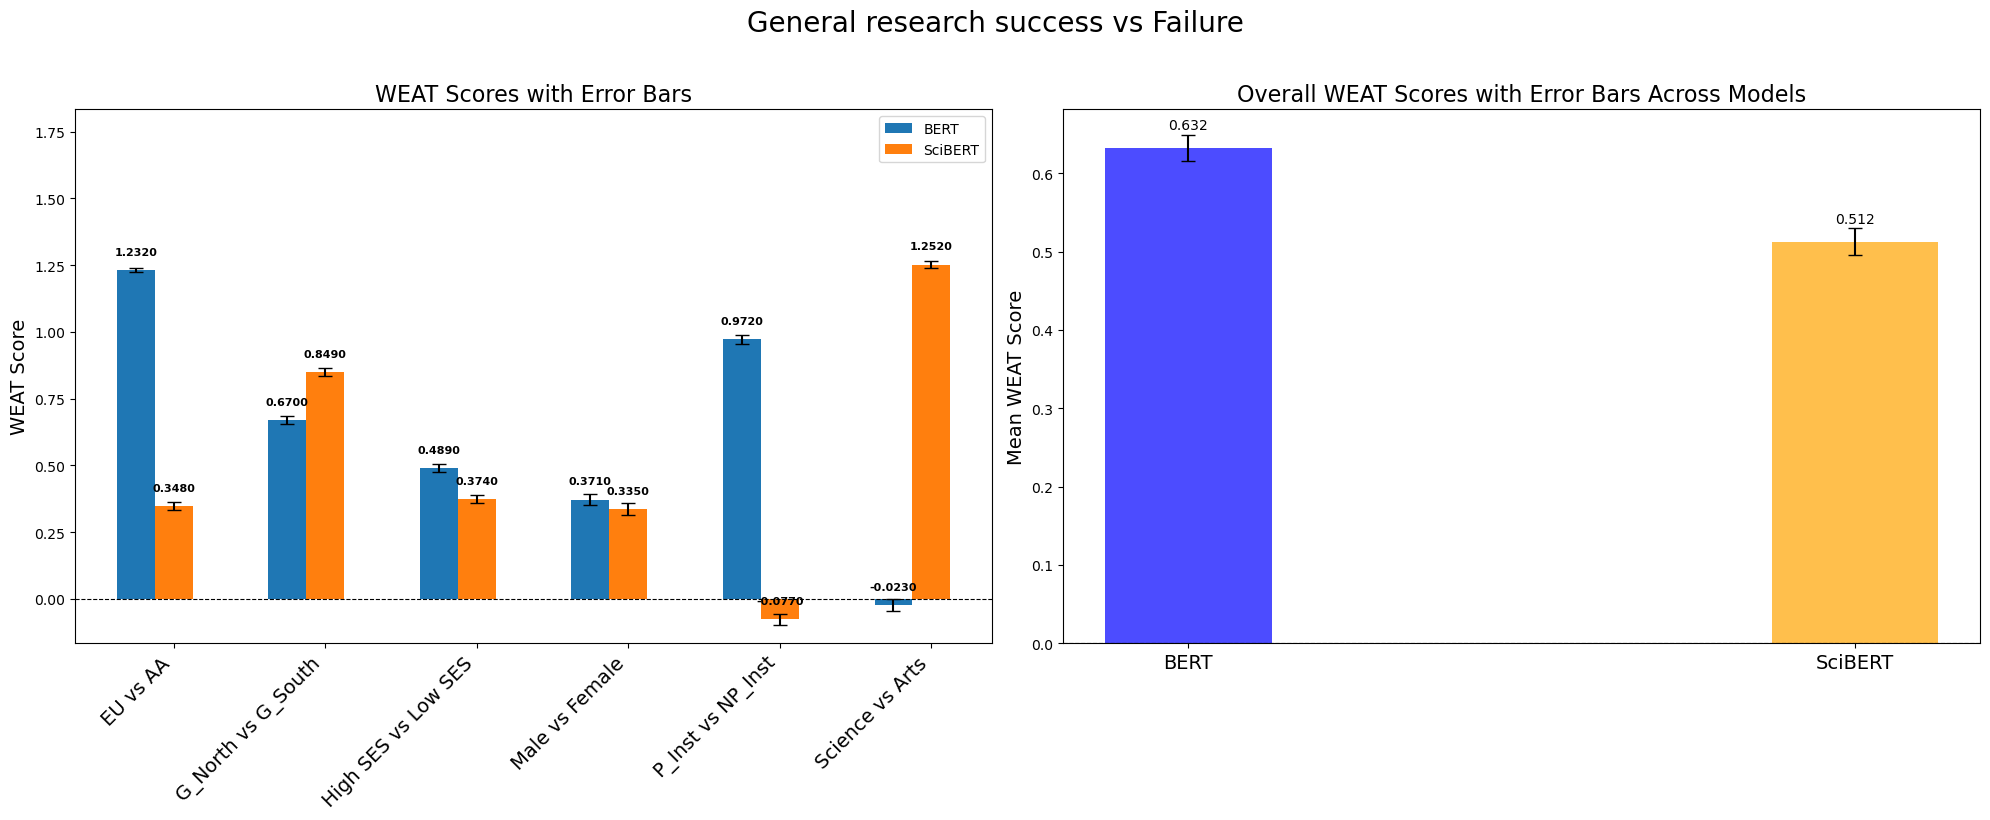

In [18]:
for model in ['BERT', 'SciBERT']:
    pivot_df1[f'Mean {model}'], pivot_df1[f'SE {model}'] = zip(*pivot_df1[f'Bootstrap Score {model}'].apply(calc_stats))

plot_df1 = pivot_df1[[col for col in pivot_df1.columns if col.startswith('WEAT Score') or col.startswith('Mean') or col.startswith('SE')]]

# Bootstrap error bars and overall error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First subplot 
width = 0.25
x = np.arange(len(plot_df1.index))

def add_bars_and_text(x_pos, data, label, ax):
    bars = ax.bar(x_pos, data, width, label=label, yerr=plot_df1[f'SE {label}'], capsize=5)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{data[i]:.4f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    return bars

add_bars_and_text(x - width, plot_df1['WEAT Score BERT'], 'BERT', ax1)
add_bars_and_text(x, plot_df1['WEAT Score SciBERT'], 'SciBERT', ax1)

ax1.set_ylabel('WEAT Score', fontsize=14)
ax1.set_title('WEAT Scores with Error Bars', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df1.index, rotation=45, ha='right', fontsize=14)
ax1.legend(fontsize=10)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
y_min, y_max = ax1.get_ylim()
ax1.set_ylim(y_min, y_max + 0.5)


# Second subplot 
means = plot_df1[['Mean BERT', 'Mean SciBERT']].mean()
ses = plot_df1[['SE BERT', 'SE SciBERT']].mean()

x = np.arange(len(means))
ax2.bar(x, means, width, yerr=ses, capsize=5, color=['blue', 'orange'], alpha=0.7)

ax2.set_ylabel('Mean WEAT Score', fontsize=14)
ax2.set_title('Overall WEAT Scores with Error Bars Across Models', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(['BERT', 'SciBERT'], fontsize=14)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

for i, v in enumerate(means):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
fig.suptitle("Teaching success vs Failure", fontsize=20, y=1.02)

plt.tight_layout()
plt.show()

In [19]:
############ Funding success vs Failure ############
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
        "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']

    },
    {
        "name": "Socioeconomic_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Awarded', 'Grant', 'Investment', 'Support', 'Endowment', 'Sponsorship',
      'Financing', 'Allocation', 'Approval', 'Backing', 'Resourceful', 'Budgeted',
      'Secured', 'Partnership', 'Subsidy', 'Recognition', 'Capital', 'Opportunity',
      'Contribution', 'Sustainability'],
      "W2": ['Rejected', 'Denial', 'Deficit', 'Withdrawal', 'Insolvency', 'Loss',
      'Underfunded', 'Refusal', 'Cutback', 'Opposition', 'Deprivation', 'Unfunded',
      'Insecurity', 'Disinterest', 'Reduction', 'Ignored', 'Debt', 'Constraint',
      'Disqualification', 'Instability']
        }
]

experiment_result_list2: List[dict] = list()
experiment_names2 = []
model_names2 = []
weat_scores2 = []
sample_scores2 = []
np.random.seed(42)


for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list2.append(experiment_result)
    
    # Extract the experiment name, model name, and WEAT score for the DataFrame
    for result in all_model_results:
        experiment_names2.append(experiment["name"])
        model_names2.append(result['model_name'])
        weat_scores2.append(result['weat_score'])
        sample_scores2.append(result["Samples weat"])

In [20]:
df2 = pd.DataFrame({
    'Experiment': experiment_names2,
    'Model': model_names2,
    'WEAT Score': weat_scores2,
    'Bootstrap scores': sample_scores2
})

df2['Experiment'] = df2['Experiment'].replace(experiment_labels)
df2['WEAT Score'] = df2['WEAT Score'].round(3)
df2['Bootstrap Score'] = df2['Bootstrap scores'].apply(lambda x: f"[{', '.join([f'{v:.2f}' for v in x])}]")
pivot_df2 = df2.pivot(index='Experiment', columns='Model', values=['WEAT Score', 'Bootstrap Score'])


pivot_df2.columns = [f'{metric} {model}' for metric, model in pivot_df2.columns]
column_order = ['WEAT Score BERT', 'WEAT Score SciBERT',
                'Bootstrap Score BERT', 'Bootstrap Score SciBERT']
pivot_df2 = pivot_df2[column_order]
pivot_df2

,WEAT Score BERT,WEAT Score SciBERT,Bootstrap Score BERT,Bootstrap Score SciBERT
Experiment,,,,
EU vs AA,1.272,0.229,"[1.13, 1.15, 1.16, 1.53, 1.19, 1.34, 1.05, 1.2...","[-0.17, 0.12, 0.69, -0.65, -0.03, 0.12, 0.62, ..."
G_North vs G_South,0.425,0.843,"[0.19, 0.75, 0.66, 0.66, 0.06, 0.58, 0.19, 0.5...","[0.79, 1.15, 0.42, 1.07, 0.64, 0.97, 1.16, 1.1..."
High SES vs Low SES,0.677,0.363,"[0.71, 0.64, 0.92, 0.25, 0.73, 0.53, 1.07, 0.4...","[0.41, 0.71, 0.65, 0.19, 0.38, 0.37, 0.62, 0.1..."
Male vs Female,0.592,0.224,"[-0.01, 0.89, 0.89, 0.55, 1.19, 1.06, 1.23, 0....","[-0.80, 0.13, 0.52, 0.07, 0.88, -0.48, 0.62, -..."
P_Inst vs NP_Inst,0.845,-0.744,"[1.24, 0.76, 1.51, 0.46, 0.85, 0.35, 1.57, 1.2...","[-0.94, -0.84, -1.01, -0.46, -0.48, 0.22, -1.0..."
Science vs Arts,-0.049,0.628,"[0.90, -0.07, -0.47, -0.17, -0.70, -1.08, 0.51...","[1.17, -0.14, 1.03, 0.64, 1.72, 0.30, -0.01, 0..."


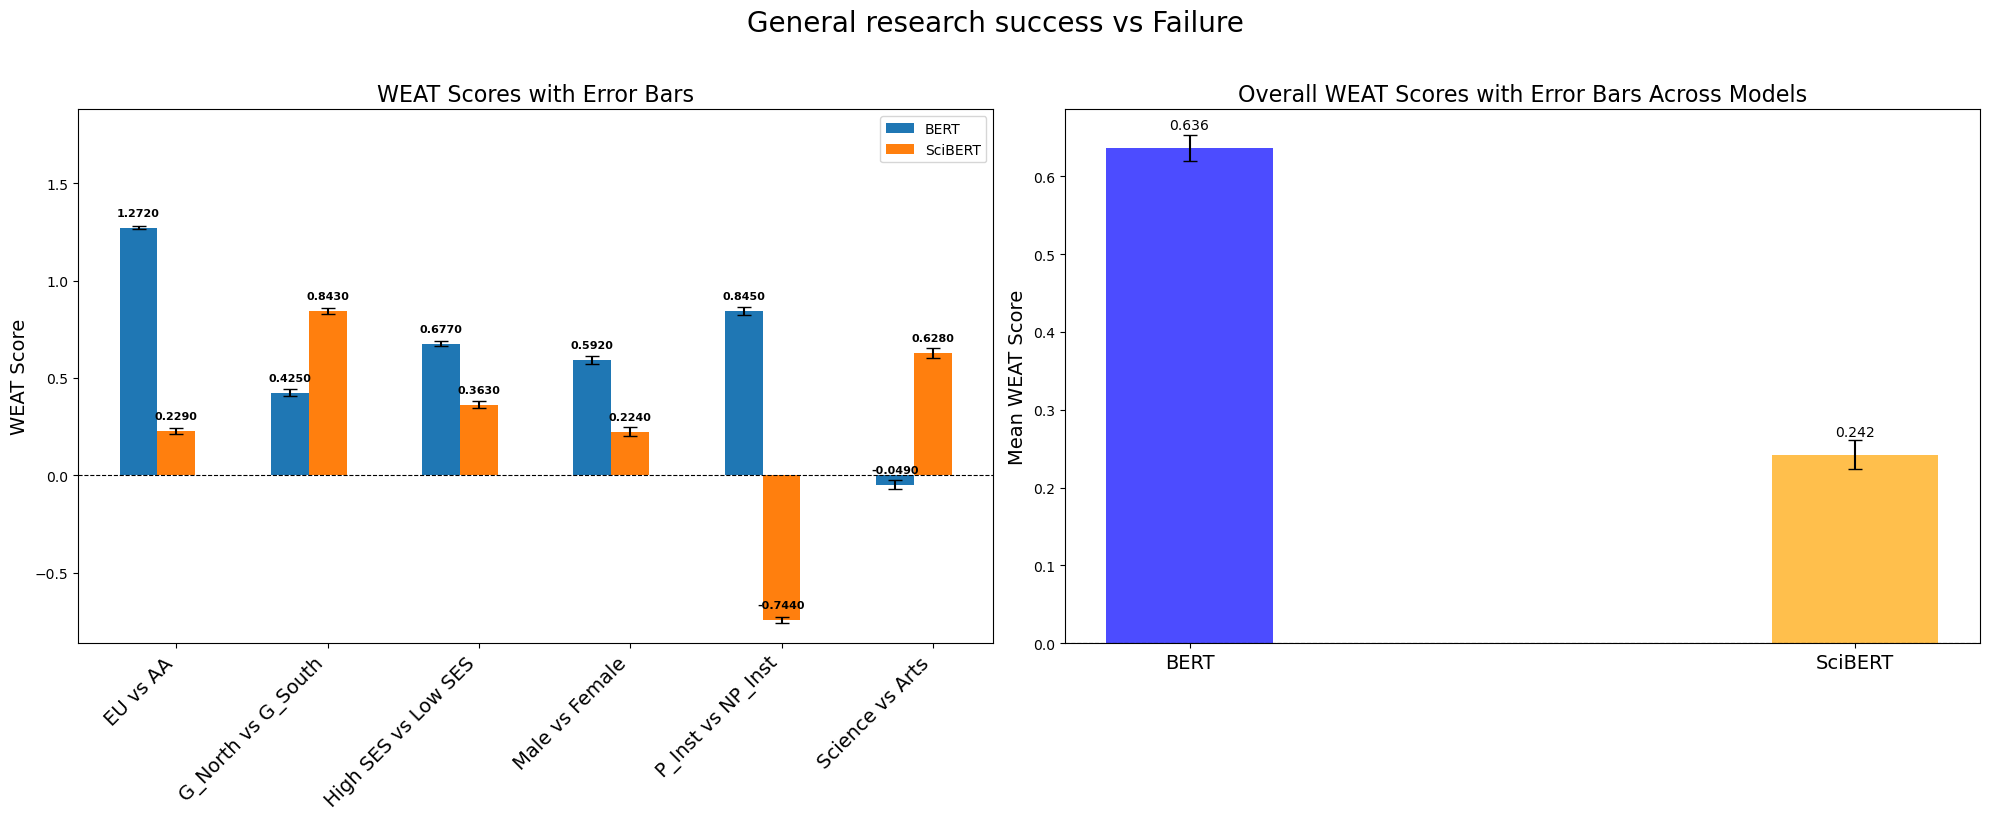

In [21]:
for model in ['BERT', 'SciBERT']:
    pivot_df2[f'Mean {model}'], pivot_df2[f'SE {model}'] = zip(*pivot_df2[f'Bootstrap Score {model}'].apply(calc_stats))
plot_df2 = pivot_df2[[col for col in pivot_df2.columns if col.startswith('WEAT Score') or col.startswith('Mean') or col.startswith('SE')]]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First plot
width = 0.25
x = np.arange(len(plot_df2.index))
def add_bars_and_text(x_pos, data, label, ax):
    bars = ax.bar(x_pos, data, width, label=label, yerr=plot_df2[f'SE {label}'], capsize=5)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{data[i]:.4f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    return bars

add_bars_and_text(x - width, plot_df2['WEAT Score BERT'], 'BERT', ax1)
add_bars_and_text(x, plot_df2['WEAT Score SciBERT'], 'SciBERT', ax1)

ax1.set_ylabel('WEAT Score', fontsize=14)
ax1.set_title('WEAT Scores with Error Bars', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df2.index, rotation=45, ha='right', fontsize=14)
ax1.legend(fontsize=10)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
y_min, y_max = ax1.get_ylim()
ax1.set_ylim(y_min, y_max + 0.5)

# Second plot
means = plot_df2[['Mean BERT', 'Mean SciBERT']].mean()
ses = plot_df2[['SE BERT', 'SE SciBERT']].mean()

x = np.arange(len(means))
ax2.bar(x, means, width, yerr=ses, capsize=5, color=['blue', 'orange'], alpha=0.7)

ax2.set_ylabel('Mean WEAT Score', fontsize=14)
ax2.set_title('Overall WEAT Scores with Error Bars Across Models', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(['BERT', 'SciBERT'], fontsize=14)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

for i, v in enumerate(means):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
fig.suptitle("Funding success vs Failure", fontsize=20, y=1.02)

plt.tight_layout()
plt.show()

In [22]:
################### Award and Recognition vs Failure ###############
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
    },
    {
        "name": "Location_bias",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
        "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']

    },
    {
        "name": "Socioeconomis_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Laureate', 'Honor', 'Prize', 'Medal', 'Distinction', 'Trophy',
      'Commendation', 'Accolade', 'Certificate', 'Achievement', 'Winner',
      'Recognition', 'Title', 'Badge', 'Nomination', 'Decoration',
      'Tribute', 'Merit', 'Celebration', 'Noteworthy'],
      "W2": ['Oversight', 'Neglect', 'Disregard', 'Failure', 'Rejection',
      'Penalty', 'Ignominy', 'Criticism', 'Disqualification', 'Defeat',
      'Unacknowledged', 'Obscurity', 'Exclusion', 'Demotion', 'Withdrawal',
      'Denial', 'Reprimand', 'Devaluation', 'Condemnation', 'Disgrace']
        }
]

experiment_result_list3: List[dict] = list()
experiment_names3 = []
model_names3 = []
weat_scores3 = []
sample_scores3 = []
np.random.seed(42)


for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list3.append(experiment_result)
    
    # Extract the experiment name, model name, and WEAT score for the DataFrame
    for result in all_model_results:
        experiment_names3.append(experiment["name"])
        model_names3.append(result['model_name'])
        weat_scores3.append(result['weat_score'])
        sample_scores3.append(result["Samples weat"])

In [57]:
df3 = pd.DataFrame({
    'Experiment': experiment_names3,
    'Model': model_names3,
    'WEAT Score': weat_scores3,
    'Bootstrap scores': sample_scores3
})

df3['Experiment'] = df3['Experiment'].replace(experiment_labels)
df3['WEAT Score'] = df3['WEAT Score'].round(3)
df3['Bootstrap Score'] = df3['Bootstrap scores'].apply(lambda x: f"[{', '.join([f'{v:.2f}' for v in x])}]")


pivot_df3 = df3.pivot(index='Experiment', columns='Model', values=['WEAT Score', 'Bootstrap Score'])
pivot_df3.columns = [f'{metric} {model}' for metric, model in pivot_df3.columns]
column_order = ['WEAT Score BERT', 'WEAT Score SciBERT', 
                'Bootstrap Score BERT', 'Bootstrap Score SciBERT']
pivot_df3 = pivot_df3[column_order]
pivot_df3

,WEAT Score BERT,WEAT Score SciBERT,Bootstrap Score BERT,Bootstrap Score SciBERT
Experiment,,,,
EU vs AA,1.227,0.733,"[1.17, 1.08, 1.15, 1.46, 1.20, 1.32, 0.99, 1.0...","[0.72, 0.98, 0.37, 0.70, 0.87, 0.82, 1.21, 1.0..."
G_North vs G_South,0.76,0.675,"[0.90, 1.08, 1.01, 1.10, 0.56, 1.16, 0.46, 1.0...","[0.80, 0.75, 1.26, 0.92, 0.31, 0.22, 0.48, 0.6..."
High SES vs Low SES,0.491,1.088,"[0.69, 0.40, 0.76, 0.11, 0.50, 0.25, 1.01, 0.0...","[1.34, 0.78, 1.19, 0.61, 1.18, 1.17, 1.29, 0.8..."
Male vs Female,0.114,0.944,"[-0.42, 0.37, 0.64, -0.13, 0.73, 0.47, 0.79, 0...","[0.67, 0.84, 0.86, 0.85, 0.98, 1.07, 0.98, 1.0..."
P_Inst vs NP_Inst,0.699,0.752,"[1.11, 0.51, 1.32, 0.28, 0.77, 0.36, 1.50, 0.9...","[0.82, 0.56, 0.23, 0.82, 0.93, 1.14, 0.58, 0.2..."
Science vs Arts,-0.822,0.775,"[-0.51, -1.35, -1.04, -0.34, -0.91, -1.59, -1....","[0.84, 0.34, 1.33, 1.16, 1.27, 0.34, 0.71, 0.4..."


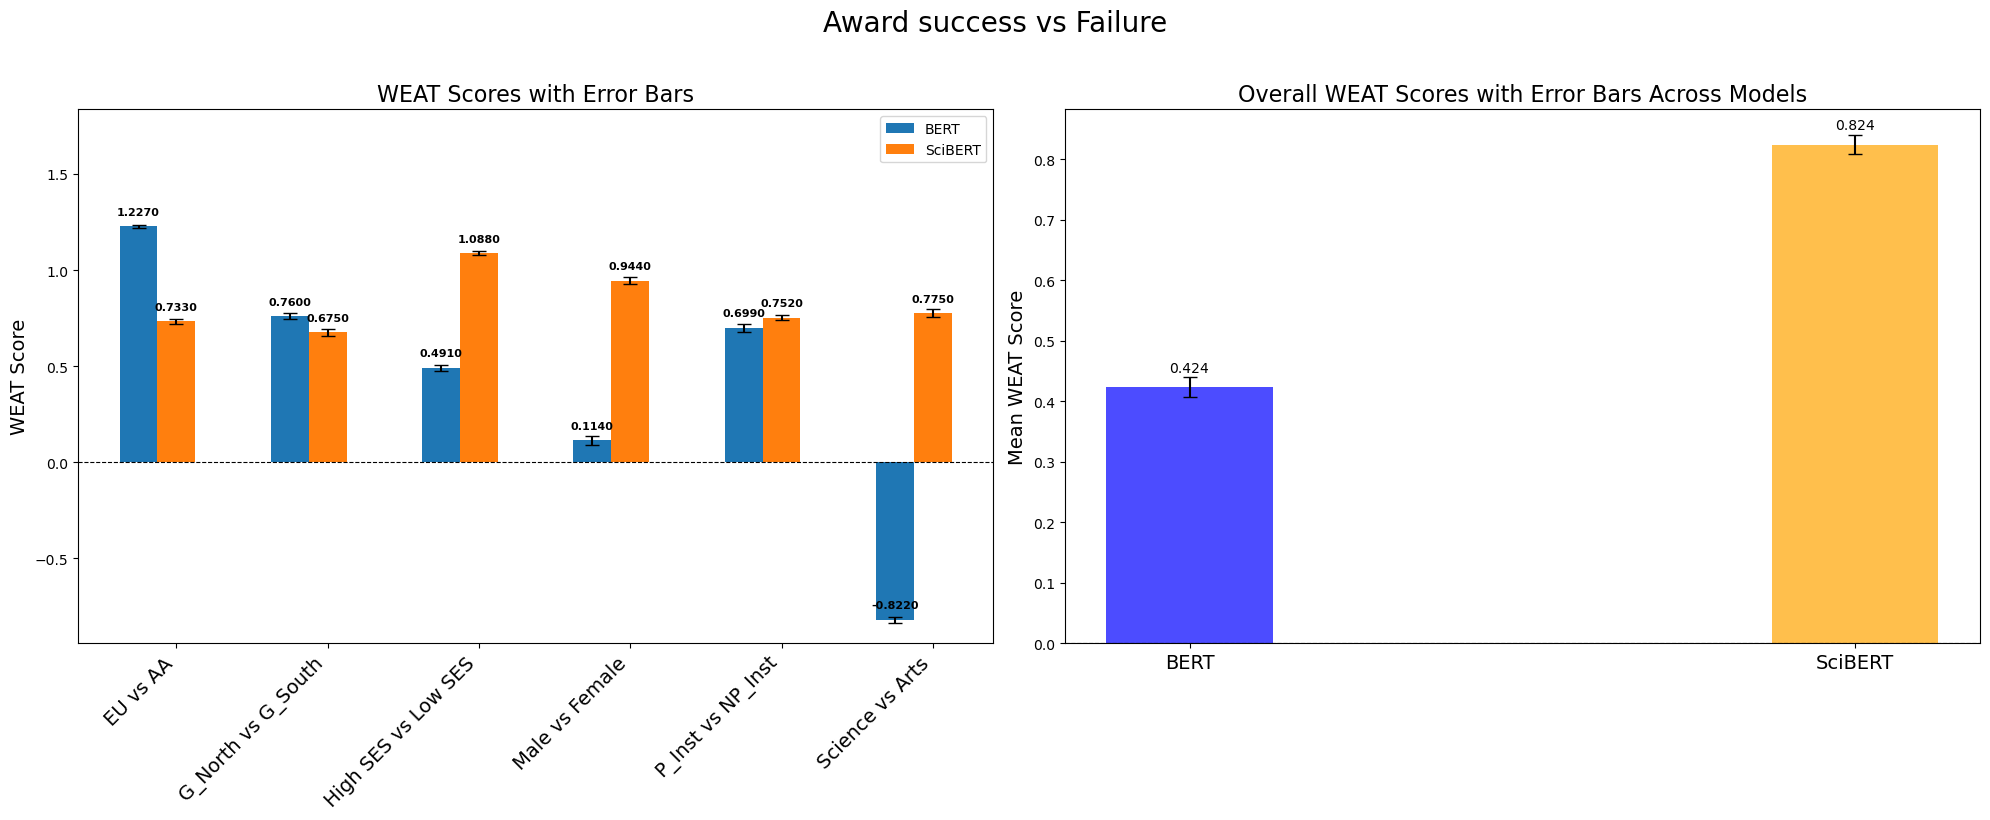

In [58]:
for model in ['BERT', 'SciBERT']:
    pivot_df3[f'Mean {model}'], pivot_df3[f'SE {model}'] = zip(*pivot_df3[f'Bootstrap Score {model}'].apply(calc_stats))
plot_df3 = pivot_df3[[col for col in pivot_df3.columns if col.startswith('WEAT Score') or col.startswith('Mean') or col.startswith('SE')]]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First plot
width = 0.25
x = np.arange(len(plot_df3.index))

def add_bars_and_text(x_pos, data, label, ax):
    bars = ax.bar(x_pos, data, width, label=label, yerr=plot_df3[f'SE {label}'], capsize=5)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{data[i]:.4f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    return bars

add_bars_and_text(x - width, plot_df3['WEAT Score BERT'], 'BERT', ax1)
add_bars_and_text(x, plot_df3['WEAT Score SciBERT'], 'SciBERT', ax1)

ax1.set_ylabel('WEAT Score', fontsize=14)
ax1.set_title('WEAT Scores with Error Bars', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df3.index, rotation=45, ha='right', fontsize=14)
ax1.legend(fontsize=10)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
y_min, y_max = ax1.get_ylim()
ax1.set_ylim(y_min, y_max + 0.5)

# Second plot
means = plot_df3[['Mean BERT', 'Mean SciBERT']].mean()
ses = plot_df3[['SE BERT', 'SE SciBERT']].mean()

x = np.arange(len(means))
ax2.bar(x, means, width, yerr=ses, capsize=5, color=['blue', 'orange'], alpha=0.7)

ax2.set_ylabel('Mean WEAT Score', fontsize=14)
ax2.set_title('Overall WEAT Scores with Error Bars Across Models', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(['BERT', 'SciBERT'], fontsize=14)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

for i, v in enumerate(means):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
fig.suptitle("Award success vs Failure", fontsize=20, y=1.02)

plt.tight_layout()
plt.show()

In [25]:
############ Research productivity and impact vs Failure #################
experiment_list: List[ExperimentSetup] = [

    {
        "name": "gender_bias",
        "A1": ["John", "Paul", "Mike", "Kevin", "Steve", "Greg", "Jeff", "Bill"],
        "A2": ["Amy", "Joan", "Lisa", "Sarah", "Diana", "Kate", "Ann", "Donna"],
        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },
    {
        "name": "race_bias",
        "A1": ["Brad", "Brendan", "Geoffrey", "Greg", "Brett", "Jay", "Matthew", "Neil", "Todd", "Allison", "Anne", "Carrie", "Emily", "Jill", "Laurie", "Kristen", "Meredith", "Sarah"],
        "A2": ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "Tyrone", "Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Tanisha"],
        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },
    {
        "name": "Field_bias",
        "A1": ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"],

        "A2": ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"],

        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },
    {
        "name": "Location",
        "A1": ["United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Norway", "Sweden", "Australia", "New Zealand"],

        "A2": ["Brazil", "India", "South Africa", "Mexico", "Argentina", "Nigeria", "Indonesia", "Kenya", "Vietnam", "Philippines"],

        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']

    },

    {
        "name": "Prestige_bias",
        "A1": ["Harvard University", "Massachusetts Institute of Technology (MIT)", "Oxford University",
                       "Stanford University", "California Institute of Technology (Caltech)", "Cambridge University",
                       "Yale University", "Princeton University", "University of Tokyo", "ETH Zurich"],


        "A2": ["University of Cape Coast", "University of Dhaka", "Federal University of Lavras",
                           "Brock University", "Jamia Millia Islamia University", "Ateneo de Manila University",
                           "Pontifical Catholic University of Peru", "Bilkent University",
                           "University of Dschang", "Universidad de los Andes"],

        "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
        "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
    },

    {
        "name": "Socioeconomis_bias",

      "A1": [
        "Wealthy", "Privileged", "Rich", "Higher-resource", "higher resource",
        "Upper-income", "upper income", "Upper-class", "upper class",
        "Economically advantaged", "Socioeconomically advantaged",
        "Affluent", "Well-off", "Elite"
    ],
      "A2": [
        "Vulnerable", "Deprived", "Poor", "Disadvantaged", "Underserved",
        "Underprivileged", "Impoverished", "(population) At risk",
        "Lower-resource", "lower resource", "Lower-income", "lower income",
        "Marginalized", "Resource-limited", "Economically disadvantaged",
        "Indigent", "Socioeconomically disadvantaged", "Working-class"
    ],
      "W1": ['Publication', 'Citation', 'Collaboration', 'High-impact', 'Peer-reviewed', 'Influence',
      'Innovation', 'Breakthrough', 'Contribution', 'Recognition', 'Prestigious', 'Indexing',
      'Originality', 'Relevance', 'Credibility', 'Visibility', 'Consistency', 'Prominence',
      'Advancement', 'Influence'],
      "W2": ['Non-publication', 'Uncited', 'Isolation', 'Low-impact', 'Unreviewed', 'Neglect',
      'Stagnation', 'Failure', 'Oversight', 'Obscurity', 'Disregarded', 'Non-indexed',
      'Plagiarism', 'Irrelevance', 'Doubt', 'Invisibility', 'Inconsistency', 'Marginality',
      'Regression', 'Ignorance']
        }
]

experiment_result_list4: List[dict] = list()
experiment_names4 = []
model_names4 = []
weat_scores4 = []
sample_scores4 = []
np.random.seed(42)


for experiment in experiment_list:
    all_model_results = run_experiment(experiment, embedding_models)
    experiment_result = {
        "name": experiment["name"],
        "results": all_model_results
    }
    experiment_result_list4.append(experiment_result)
    
    # Extract the experiment name, model name, and WEAT score for the DataFrame
    for result in all_model_results:
        experiment_names4.append(experiment["name"])
        model_names4.append(result['model_name'])
        weat_scores4.append(result['weat_score'])
        sample_scores4.append(result["Samples weat"])

In [55]:
df4 = pd.DataFrame({
    'Experiment': experiment_names4,
    'Model': model_names4,
    'WEAT Score': weat_scores4,
    'Bootstrap scores': sample_scores4
})

df4['Experiment'] = df4['Experiment'].replace(experiment_labels)
df4['WEAT Score'] = df4['WEAT Score'].round(3)
df4['Bootstrap Score'] = df4['Bootstrap scores'].apply(lambda x: f"[{', '.join([f'{v:.2f}' for v in x])}]")
pivot_df4 = df4.pivot(index='Experiment', columns='Model', values=['WEAT Score', 'Bootstrap Score'])


pivot_df4.columns = [f'{metric} {model}' for metric, model in pivot_df4.columns]
column_order = ['WEAT Score BERT', 'WEAT Score SciBERT', 
                'Bootstrap Score BERT', 'Bootstrap Score SciBERT']
pivot_df4 = pivot_df4[column_order]
pivot_df4

,WEAT Score BERT,WEAT Score SciBERT,Bootstrap Score BERT,Bootstrap Score SciBERT
Experiment,,,,
EU vs AA,1.226,0.768,"[1.08, 1.07, 1.12, 1.50, 1.16, 1.26, 0.98, 1.2...","[0.58, 1.02, 1.04, 0.18, 0.69, 0.60, 0.86, 1.0..."
G_North vs G_South,0.524,1.199,"[0.38, 0.88, 0.70, 0.80, 0.36, 0.83, 0.24, 0.7...","[1.05, 1.38, 0.75, 0.96, 1.34, 1.50, 1.44, 1.3..."
High SES vs Low SES,0.519,0.433,"[0.61, 0.44, 0.74, 0.10, 0.57, 0.29, 0.98, 0.1...","[0.56, 0.15, 0.79, 0.42, 0.80, 0.62, 0.88, 0.7..."
Male vs Female,0.285,0.276,"[-0.36, 0.63, 0.67, 0.09, 0.81, 0.79, 0.71, 0....","[0.34, 0.19, 0.49, 0.37, 0.85, -0.68, 0.57, 0...."
P_Inst vs NP_Inst,0.915,-0.692,"[1.30, 0.72, 1.54, 0.57, 0.88, 0.47, 1.61, 1.2...","[-1.26, -1.01, -0.61, 0.26, -0.66, -0.44, -0.9..."
Science vs Arts,-0.127,0.848,"[0.56, -0.25, -0.61, -0.03, -0.84, -1.22, 0.31...","[1.27, 0.43, 1.24, 0.95, 1.33, 0.71, 0.77, 0.6..."


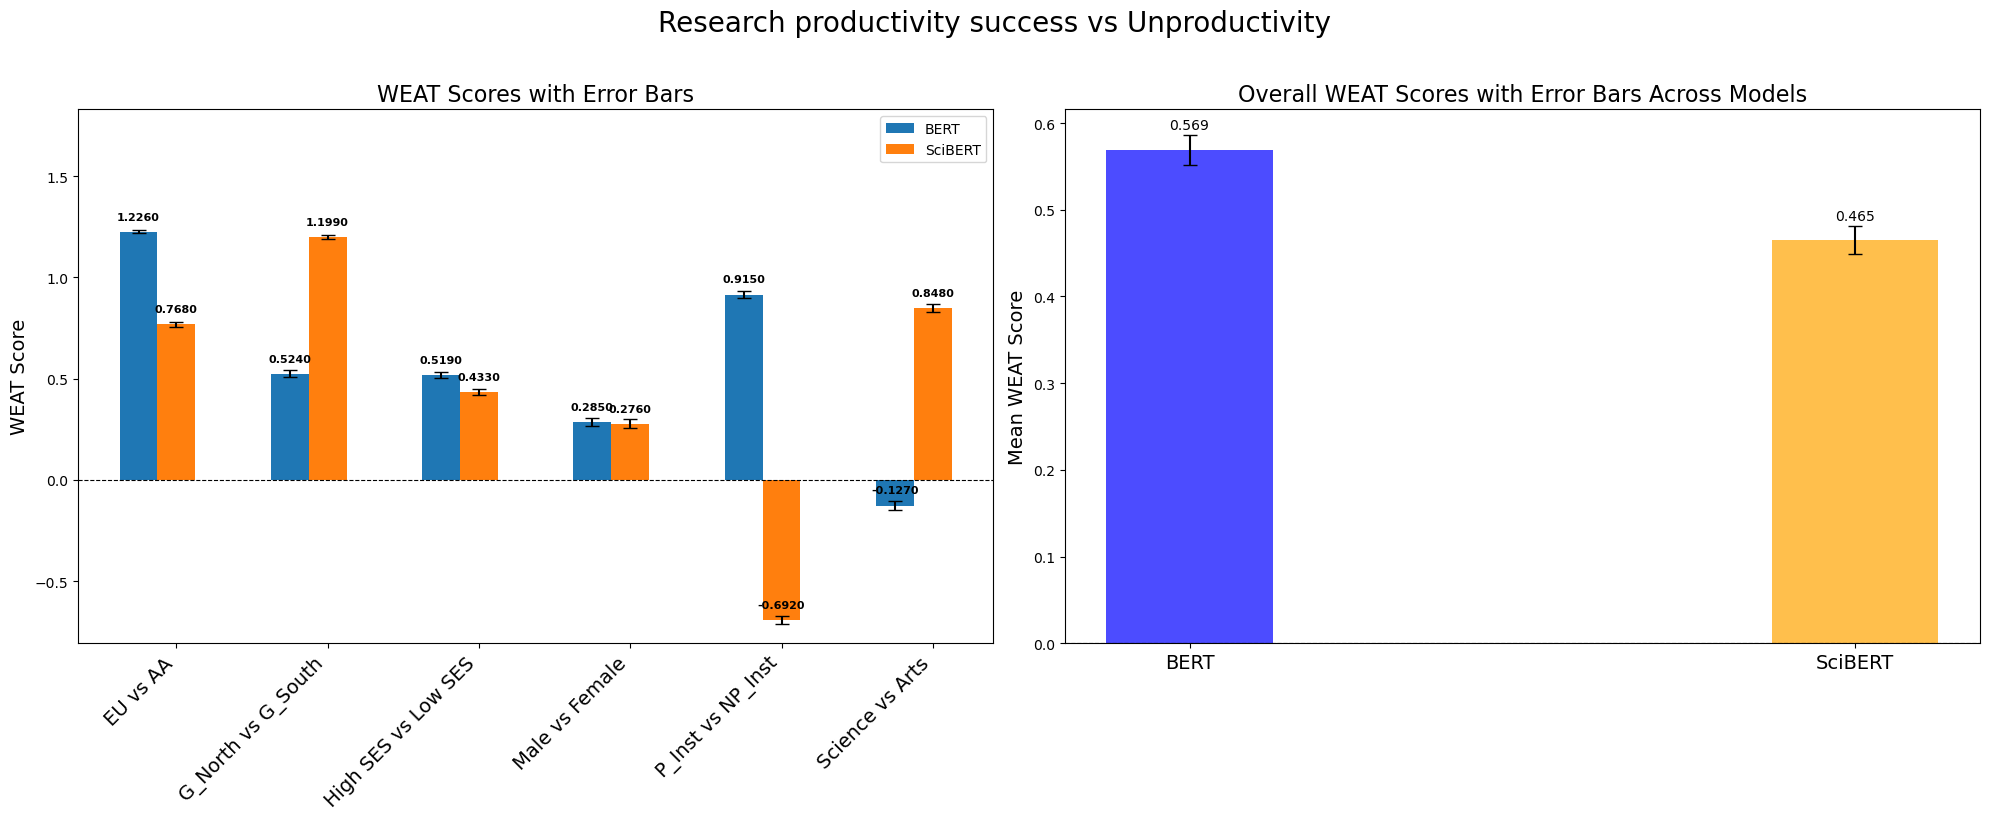

In [56]:
for model in ['BERT', 'SciBERT']:
    pivot_df4[f'Mean {model}'], pivot_df4[f'SE {model}'] = zip(*pivot_df4[f'Bootstrap Score {model}'].apply(calc_stats))
plot_df4 = pivot_df4[[col for col in pivot_df4.columns if col.startswith('WEAT Score') or col.startswith('Mean') or col.startswith('SE')]]

# Bootstrap error bars and overall error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First plot
width = 0.25
x = np.arange(len(plot_df4.index))

def add_bars_and_text(x_pos, data, label, ax):
    bars = ax.bar(x_pos, data, width, label=label, yerr=plot_df4[f'SE {label}'], capsize=5)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{data[i]:.4f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    return bars

add_bars_and_text(x - width, plot_df4['WEAT Score BERT'], 'BERT', ax1)
add_bars_and_text(x, plot_df4['WEAT Score SciBERT'], 'SciBERT', ax1)

ax1.set_ylabel('WEAT Score', fontsize=14)
ax1.set_title('WEAT Scores with Error Bars', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df4.index, rotation=45, ha='right', fontsize=14)
ax1.legend(fontsize=10)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
y_min, y_max = ax1.get_ylim()
ax1.set_ylim(y_min, y_max + 0.5)

# Second plot
means = plot_df4[['Mean BERT', 'Mean SciBERT']].mean()
ses = plot_df4[['SE BERT', 'SE SciBERT']].mean()

x = np.arange(len(means))
ax2.bar(x, means, width, yerr=ses, capsize=5, color=['blue', 'orange'], alpha=0.7)

ax2.set_ylabel('Mean WEAT Score', fontsize=14)
ax2.set_title('Overall WEAT Scores with Error Bars Across Models', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(['BERT', 'SciBERT'], fontsize=14)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

for i, v in enumerate(means):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
fig.suptitle("Research productivity success vs Unproductivity", fontsize=20, y=1.02)

plt.tight_layout()
plt.show()

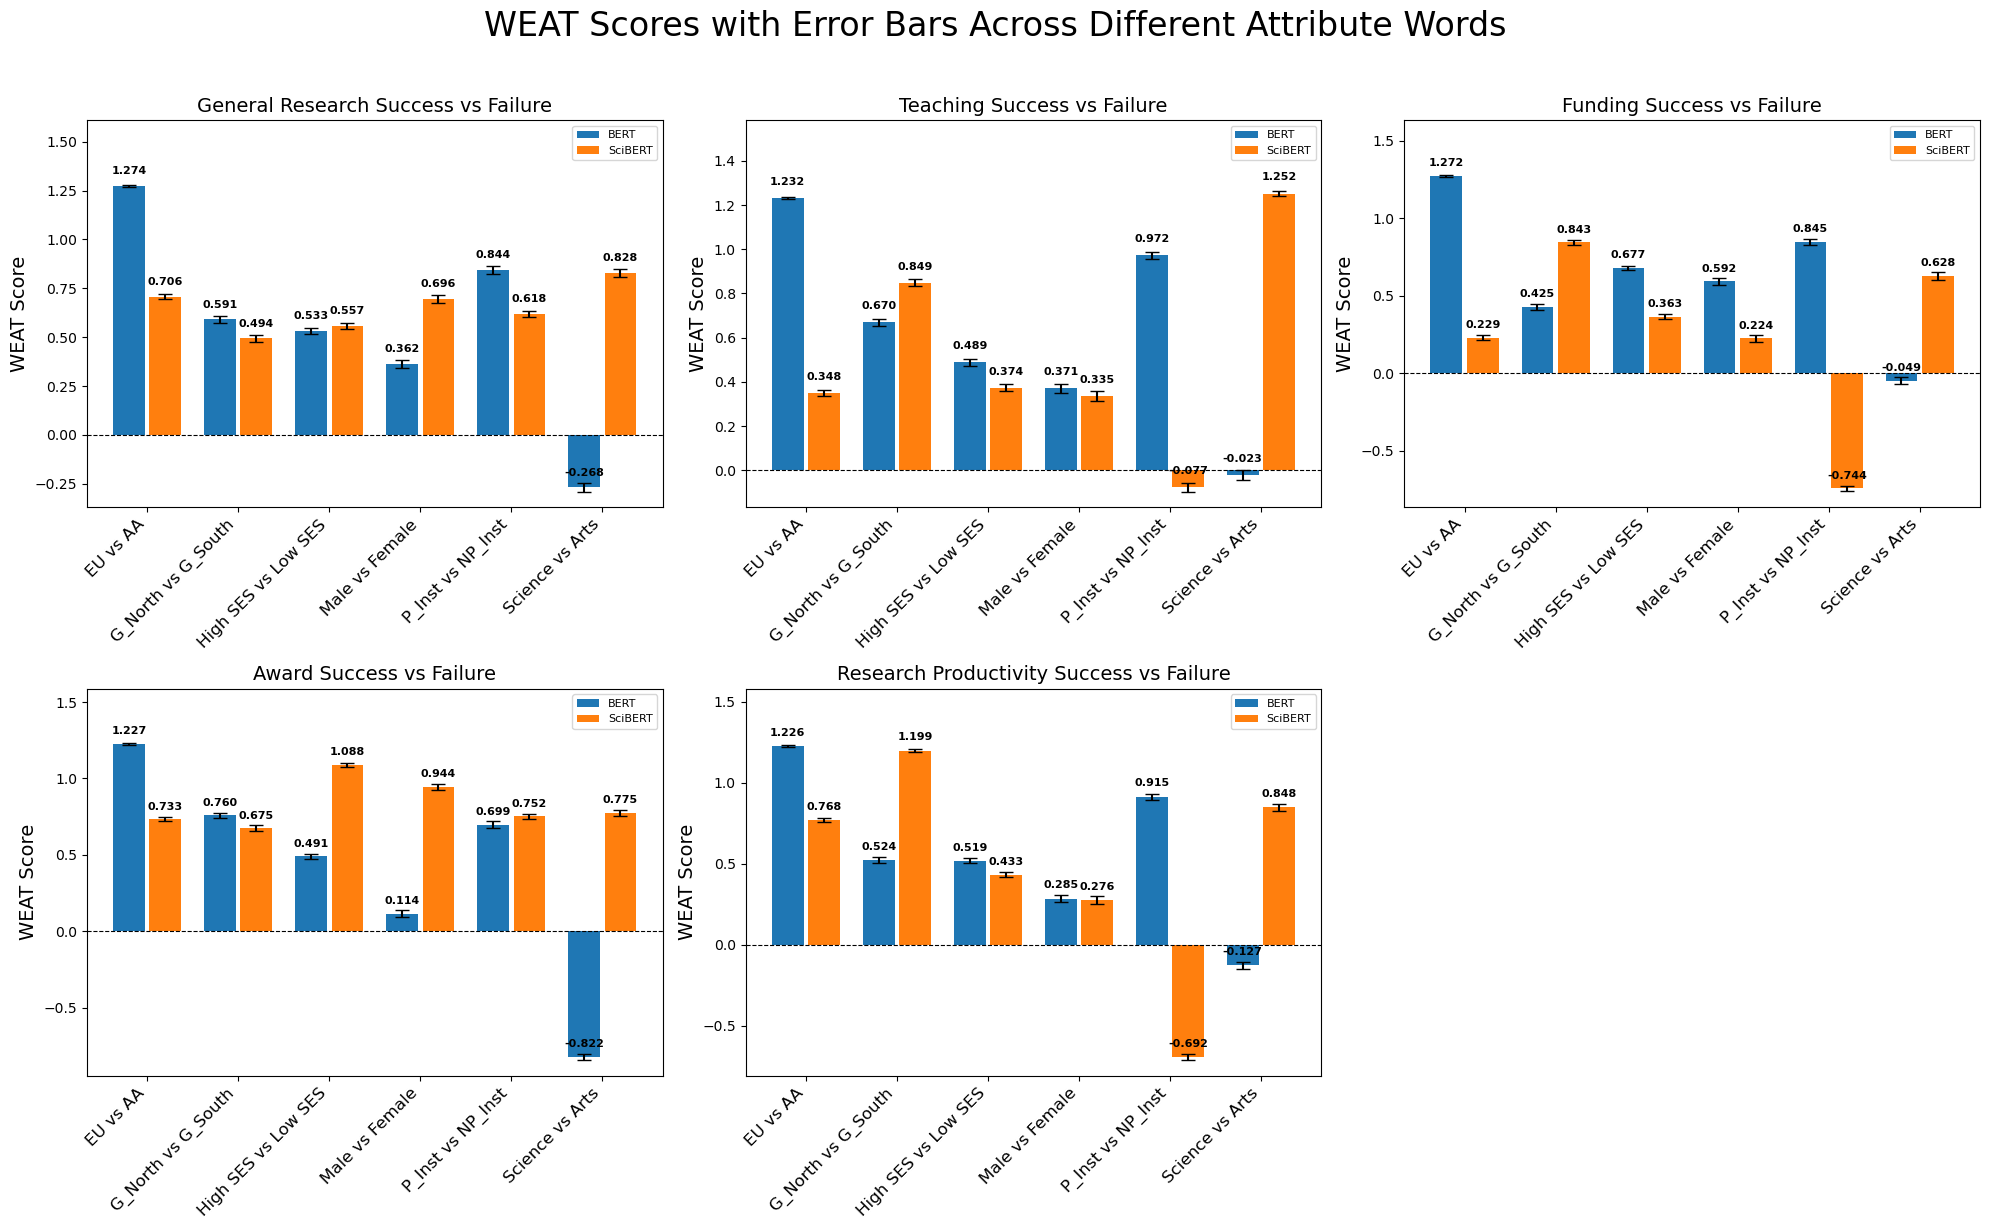

In [59]:

def add_bars_and_text(x_pos, data, label, ax, se_data):
    width = 0.35
    bars = ax.bar(x_pos, data, width, label=label, yerr=se_data, capsize=5)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{data[i]:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    return bars

dataframes = [plot_df, plot_df1, plot_df2, plot_df3, plot_df4]
titles = ["General Research", "Teaching", "Funding", "Award", "Research Productivity"]

fig1, axs1 = plt.subplots(2, 3, figsize=(20, 12))
fig1.suptitle("WEAT Scores with Error Bars Across Different Attribute Words", fontsize=24, y=1.02)
for i, (df, title) in enumerate(zip(dataframes, titles)):
    ax = axs1[i // 3, i % 3]
    x = np.arange(len(df.index))
    add_bars_and_text(x - 0.2, df['WEAT Score BERT'], 'BERT', ax, df['SE BERT'])
    add_bars_and_text(x + 0.2, df['WEAT Score SciBERT'], 'SciBERT', ax, df['SE SciBERT'])
    
    ax.set_ylabel('WEAT Score', fontsize=14)
    ax.set_title(f'{title} Success vs Failure', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=8)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_max + 0.25)


fig1.delaxes(axs1[1, 2])

plt.tight_layout()
plt.savefig("weat_scores_with_error_bars.png", dpi=300, bbox_inches="tight")
plt.show()

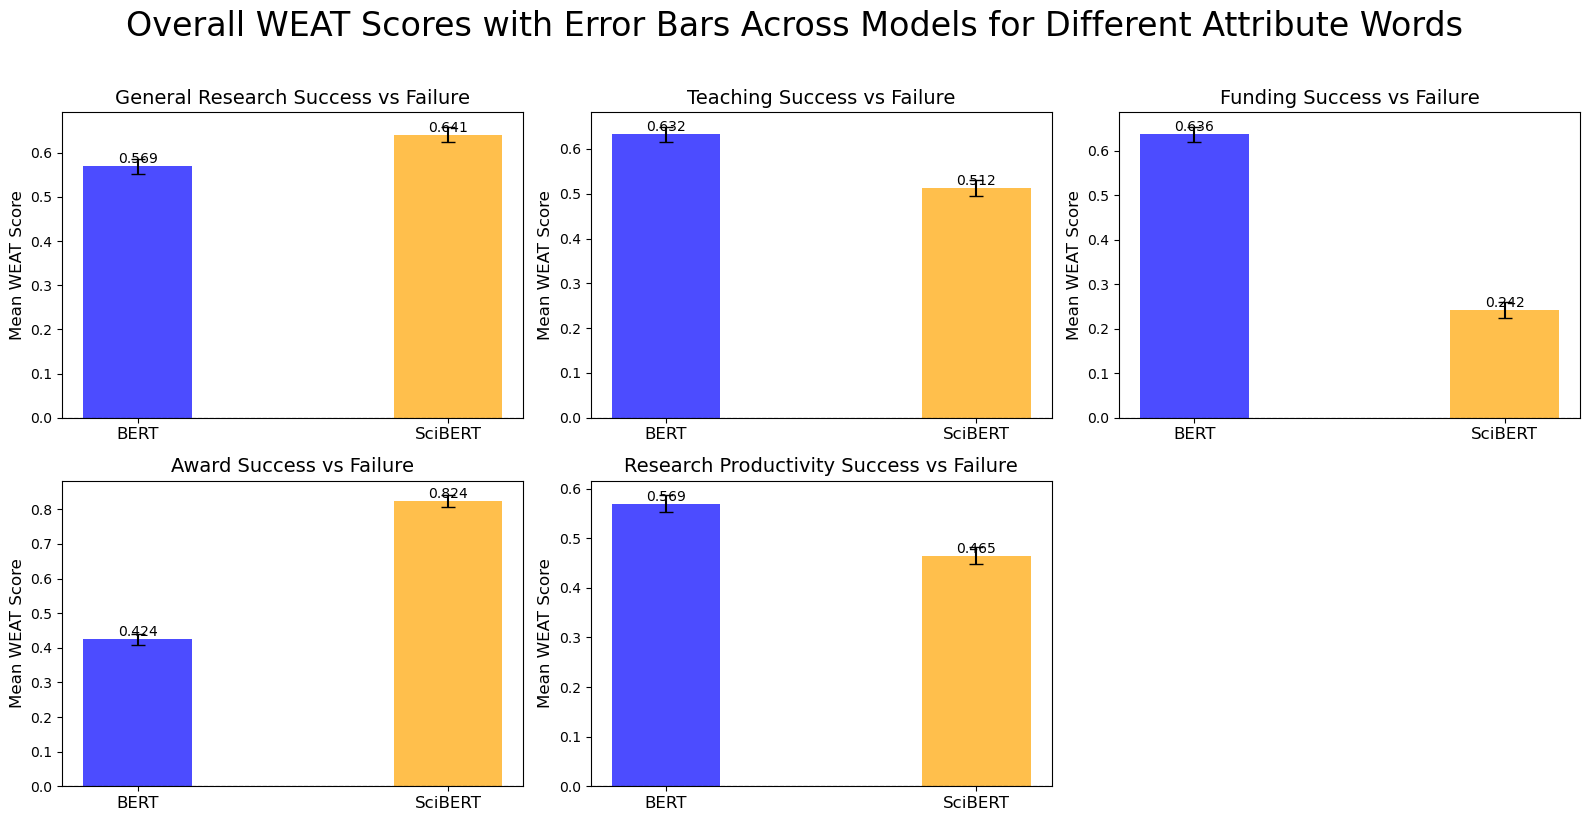

In [60]:
fig2, axs2 = plt.subplots(2, 3, figsize=(16, 8))
fig2.suptitle("Overall WEAT Scores with Error Bars Across Models for Different Attribute Words", fontsize=24, y=1.02)

for i, (df, title) in enumerate(zip(dataframes, titles)):
    ax = axs2[i // 3, i % 3]
    means = df[['Mean BERT', 'Mean SciBERT']].mean()
    ses = df[['SE BERT', 'SE SciBERT']].mean()
    
    x = np.arange(len(means))
    width = 0.35
    ax.bar(x, means, width, yerr=ses, capsize=5, color=['blue', 'orange'], alpha=0.7)
    
    ax.set_ylabel('Mean WEAT Score', fontsize=12)
    ax.set_title(f'{title} Success vs Failure', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(['BERT', 'SciBERT'], fontsize=12)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
    
    for j, v in enumerate(means):
        ax.text(j, v, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    
fig2.delaxes(axs2[1, 2])

plt.tight_layout()
plt.savefig("overall_weat_scores_across_models.png", dpi=300, bbox_inches="tight")
plt.show()